# Deep Learning | Convolutional Neural Networks

In this laboratory session I train some CNNs to recognize images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).


## Part 1: Initial Setup and Data Exploration

I begin with some standard imports, as usual.

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Validation set size.
val_size = 2000

# Your code here.

#### Download and transformation to tensor of the data, divided into training and test sets.

In [ ]:
training_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 170498071/170498071 [00:02<00:00, 79354760.66it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### Function to calculate mean and std deviation of data for each channel separately
Used later to standardize and unstandardize the values.

In [ ]:
def mean_std_calc(data):

    # Concatenate tensors along a new dimension, as a tensor with the shape (num_imgs, C, H, W)
    imgs = torch.stack([item[0] for item in data], dim=0) # item[0] image, item[1] label

    # Calculate mean and standard deviation along the 3 RGB channels indipendently across all images in dataset:
    # dim=(0, 2, 3) means that the mean and standard deviation will be calculated separately along each of these dimensions.
    mean = imgs.mean(dim=(0, 2, 3))
    std = imgs.std(dim=(0, 2, 3))

    return mean, std

Just looking at some values to understand the format.

In [ ]:
# Exploring data type
for item in training_data:  # (label + 3 x 32 x 32) per image in dataset
  print(item[0].shape)
  print(item[0][2][31].shape)
  print(item[0][2][31][31])
  print(item[1])
  break

torch.Size([3, 32, 32])
torch.Size([32])
tensor(0.2824)
6


Labels are integers, values are float and every image is made by 3 channels (R,G,B) with 32 x 32 pixels.

#### Compute mean and std dev for every split of the dataset

In [ ]:
mean_tr, std_tr = mean_std_calc(training_data)

print(f'[R,G,B] values of:\n'
      f'Mean in training data:\t{mean_tr}\n'
      f'std  in training data:\t{std_tr}')

[R,G,B] values of:
Mean in training data:	tensor([0.4914, 0.4822, 0.4465])
std  in training data:	tensor([0.2470, 0.2435, 0.2616])


Notice that values are normalized between [0,1] float (expected 0.5 mean and 0.25 std dev). Real values discard a little.

In [ ]:
mean_te, std_te = mean_std_calc(test_data)

print(f'[R,G,B] values of:\n'
      f'Mean in test data:\t{mean_te}\n'
      f'Std  in test data:\t{std_te}')

[R,G,B] values of:
Mean in test data:	tensor([0.4942, 0.4851, 0.4504])
Std  in test data:	tensor([0.2467, 0.2429, 0.2616])


#### Function to standardize values

Re-download dataset, transform to tensors and standardize.

In [ ]:
# standardizing: make mean=0 and std=1

def transform(mean, std):
    return transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

training_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform(mean_tr, std_tr))

test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform(mean_te, std_te))

Files already downloaded and verified
Files already downloaded and verified


#### Calculate mean and std dev among all standardized dataset

In [ ]:
mean_tr_n, std_tr_n = mean_std_calc(training_data)

print(f'[R,G,B] values of:\n'
      f'Mean in standardized training data:\t{mean_tr_n}\n'
      f'Std  in standardized training data:\t{std_tr_n}\n')

mean_te_n, std_te_n = mean_std_calc(test_data)

print(f'[R,G,B] values of:\n'
      f'Mean in standardized test data:\t{mean_te_n}\n'
      f'Std  in standardized test data:\t{std_te_n}')

[R,G,B] values of:
Mean in standardized training data:	tensor([-4.5197e-06, -2.3309e-06, -4.8446e-08])
Std  in standardized training data:	tensor([1.0000, 1.0000, 1.0000])

[R,G,B] values of:
Mean in standardized test data:	tensor([ 1.0004e-07, -3.2295e-06, -3.2450e-06])
Std  in standardized test data:	tensor([1., 1., 1.])


#### Split dataset into train, validation and test sets

In [ ]:
import torch.utils.data as Data
torch.manual_seed(23)

train_size = len(training_data) - val_size

train_data, valid_data = Data.random_split(training_data, [train_size, val_size])

print(f'Elements in train set:\t{len(train_data)}\n'
      f'Elements in valid set:\t{len(valid_data)}\n'
      f'Elements in test set:\t{len(test_data)}')

Elements in train set:	48000
Elements in valid set:	2000
Elements in test set:	10000


In [ ]:
mean_tr_n, std_tr_n = mean_std_calc(train_data)

print(f'[R,G,B] values of:\n'
      f'Mean in train data:\t{mean_tr_n}\n'
      f'Std  in train data:\t{std_tr_n}\n')

mean_va_n, std_va_n = mean_std_calc(valid_data)

print(f'[R,G,B] values of:\n'
      f'Mean in valid data:\t{mean_va_n}\n'
      f'Std  in valid data:\t{std_va_n}\n')

[R,G,B] values of:
Mean in train data:	tensor([-0.0004, -0.0008, -0.0009])
Std  in train data:	tensor([0.9998, 0.9997, 0.9996])

[R,G,B] values of:
Mean in valid data:	tensor([0.0106, 0.0193, 0.0212])
Std  in valid data:	tensor([1.0056, 1.0071, 1.0097])



#### Dictionary to map classes' labels

In [ ]:
# Create a dict to map labels
labels_map = {}

for index, elem in enumerate(training_data.classes):
    labels_map[index] = elem

labels_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [ ]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256

# Your code here.

#### Set up DataLoaders

Investigating data, I can see again, size of tensors, float and int datatype respectively for images and labels.

Number of elements in every dataset, batch and number of batches.

In [ ]:
from torch.utils.data import DataLoader

train_DL = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_DL = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_DL  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

dataloaders = [train_DL, valid_DL, test_DL]

for loader in dataloaders:
    print(f"Processing {loader.dataset}")

    for batch in loader:
        img, labels = batch
        print(f"\nShape of a img batch: {img.shape}")
        print(f"Type of img in batch: {type(img)}")
        print(f"Type of single value in img tensor: {type(img[0][0][0][0].item())}")

        print(f"\nShape of labels batch: {labels.shape}")
        print(f"Type of labels in batch: {type(labels)}")
        print(f"Type of single label: {type(labels[0].item())}")

        print(f"\nElements: {len(loader.dataset)}")
        print(f"Batches: {len(loader)}")

        break  # Print the shape of the first batch only

    print(f'{"=" * 20}\n')

Processing <torch.utils.data.dataset.Subset object at 0x7814a5eefbb0>

Shape of a img batch: torch.Size([256, 3, 32, 32])
Type of img in batch: <class 'torch.Tensor'>
Type of single value in img tensor: <class 'float'>

Shape of labels batch: torch.Size([256])
Type of labels in batch: <class 'torch.Tensor'>
Type of single label: <class 'int'>

Elements: 48000
Batches: 188

Processing <torch.utils.data.dataset.Subset object at 0x7814a5eee980>

Shape of a img batch: torch.Size([256, 3, 32, 32])
Type of img in batch: <class 'torch.Tensor'>
Type of single value in img tensor: <class 'float'>

Shape of labels batch: torch.Size([256])
Type of labels in batch: <class 'torch.Tensor'>
Type of single label: <class 'int'>

Elements: 2000
Batches: 8

Processing Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.4942, 0.4851, 0.4504]), std=tensor([0.2467, 

#### Function to de-standardize images and make them clear once shown

In [ ]:
# Put back on the RGB float range of 0..1, so inverse of standardizin'
def unnormalize(tensor, mean, std):
    # Element-wise denormalization: tensor = (tensor * std) + mean
    tensor = tensor * torch.Tensor(std).clone().detach().view(-1, 1, 1) + torch.Tensor(mean).clone().detach().view(-1, 1, 1)
    return tensor

#### Plot random images

Images are really low quality, 32x32, but still I can understand quite clearly what it represents. Of course it depends on the specific image.

During the journey of plotting, I was de-standardizing without adding back the mean value, so images appeared darker due to this shift and were barely recognizable.

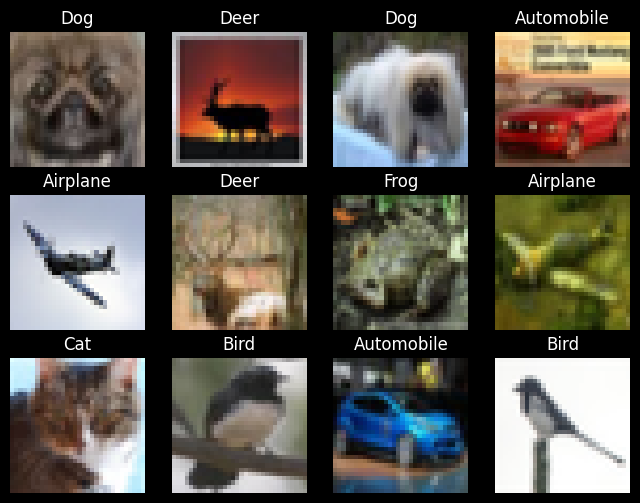

In [ ]:
# Plot of some images
figure = plt.figure(figsize=(8, 6))
cols, rows = 4, 3
#torch.manual_seed(23)

for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label].title())  # title: make first letters capital
    plt.axis("off")
    plt.imshow(unnormalize(img, mean_tr, std_tr).permute(1,2,0))  # Highth, Width, Channels | Matplotlib wants C as latter

plt.show()

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

#### CPU vs GPU
Cuda is optimized processor for ML operations.

Testing some CNN models, the training process lasted for about 1:40 hour with CPU and for 6:20 minutes in CUDA.

In [ ]:
# Move the model to cuda (if available)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(f'Device: {device}\n')

Device: cuda



#### MLP
Very simple MLP with decreasing size of hidden layers.

After some tests, I've chosen this setting as a best trade-off between complexity and performace, considering that amount of parameters in fully connected layers easily grow.

In [ ]:
# Your code here.
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sb


class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(

            nn.Linear(32*32*3, 256),  # self input size
            nn.ReLU(),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 10),
            )

    def forward(self, x):
        x = self.flatten(x)  # get me a 1x... vector
        logits = self.linear_relu_stack(x)  # get me the logits
        return logits

In [ ]:
torch.manual_seed(23)

MLP_model = MultiLayerPerceptron()
MLP_model
#MLP_model.state_dict()

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

#### Calling Function

The NeuralNetwork function is defined to:
- Set the model
- Set model parameters
- Set SGD optimizer
- Transfer the model all needed variables and data
- Perfom a training process of the model
- Test out the model on the validation set and select the parameters at the best performed epoch
- Print some verbose info about: Prosess, Epoch, Loss, Batch, Accuracy
- Plot a graph: Train vs Valid loss over epochs
- Save parameters to test the model later

In [ ]:
import copy

def NeuralNetwork(model,
                  train_DL=train_DL,
                  valid_DL=valid_DL,
                  epochs=20,
                  learning_rate=0.1,
                  lr_change = 0.8,  # set = 1 to have no changes
                  seed=23):

    torch.manual_seed(seed)

    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    size_tr = len(train_DL.dataset)
    size_va = len(valid_DL.dataset)

    train_loss_epoch = []  # List to store training losses for each epoch
    valid_loss_epoch = []

    best_epoch = 0
    best_valid_loss = float('inf')
    best_model_params = None

    for epoch in range(1, epochs+1):

        # training
        print(f"\nEpoch:\t{epoch} with Learning Rate: {round(optimizer.param_groups[0]['lr'], 4)}\n")

        train_loss = 0
        model = model.to(device)
        model.train()  # put model in training mode

        for batch, (X, y) in enumerate(train_DL):
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fun(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss_fun(pred, y).item()

            if batch % 20 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size_tr:>5d}]  batch: {batch}")

        train_loss /= len(train_DL)
        train_loss_epoch.append(train_loss)  # Append training loss to the list for plotting

        # Decreasing learning rate in each epoch
        optimizer.param_groups[0]["lr"] = learning_rate * (lr_change ** (epoch+1))

        # Validation
        valid_loss = 0
        correct_va = 0

        with torch.no_grad():
            model.eval() # model in eval mode

            for X, y in valid_DL:
                X = X.to(device)
                y = y.to(device)

                pred = model(X)
                valid_loss += loss_fun(pred, y).item()
                correct_va += (pred.argmax(1) == y).type(torch.float).sum().item()

        valid_loss /= len(valid_DL)
        valid_loss_epoch.append(valid_loss)

        correct_va /= size_va
        print(f"Validation Error: \n Accuracy: {(100*correct_va):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

        # Check if current model has the lowest validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_model_params = copy.deepcopy(model.state_dict())


    # Plot Train and Valid Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_loss_epoch, marker='o', linestyle='-', color='orange', label='Training Loss')
    plt.plot(range(1, epochs + 1), valid_loss_epoch, marker='o', linestyle='-', color='green', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train & Valid Losses')
    plt.legend()
    plt.show()

    # Load the best model parameters for testing
    model.load_state_dict(best_model_params)

    print(f"\nBest model on Validation is at epoch: {best_epoch}")

    return best_model_params, model  # access the trained model outside the function

#### First MLP model training

Here, a basic training of the MLP model with 20 epoch and a fixed lr = 0.1 over epochs.


Epoch:	1 with Learning Rate: 0.1

loss: 2.321432  [    0/48000]  batch: 0
loss: 2.009613  [ 5120/48000]  batch: 20
loss: 1.900245  [10240/48000]  batch: 40
loss: 1.762843  [15360/48000]  batch: 60
loss: 1.789327  [20480/48000]  batch: 80
loss: 1.689447  [25600/48000]  batch: 100
loss: 1.651012  [30720/48000]  batch: 120
loss: 1.778433  [35840/48000]  batch: 140
loss: 1.636936  [40960/48000]  batch: 160
loss: 1.734419  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 40.6%, Avg loss: 1.652033 


Epoch:	2 with Learning Rate: 0.1

loss: 1.680654  [    0/48000]  batch: 0
loss: 1.693215  [ 5120/48000]  batch: 20
loss: 1.674421  [10240/48000]  batch: 40
loss: 1.534728  [15360/48000]  batch: 60
loss: 1.544288  [20480/48000]  batch: 80
loss: 1.567630  [25600/48000]  batch: 100
loss: 1.424918  [30720/48000]  batch: 120
loss: 1.410232  [35840/48000]  batch: 140
loss: 1.585346  [40960/48000]  batch: 160
loss: 1.617956  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 46.5%, Avg los

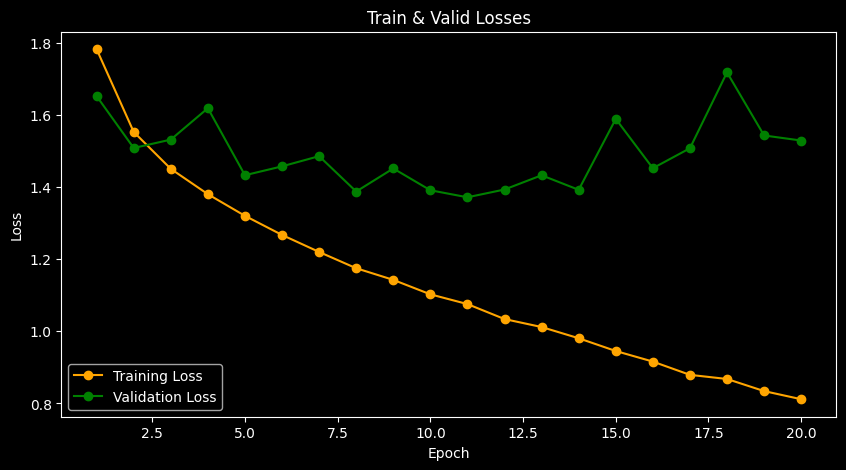


Best model on Validation is at epoch: 11


In [ ]:
torch.manual_seed(23)
MLP_model = MultiLayerPerceptron()  # Resest of model parameters

best_model_params_test_1 = NeuralNetwork(MLP_model,
                                         epochs=20,
                                         lr_change=1)

As expected, the training loss curve is monotonically decreasing while the validation decreases and around epoch 11 it starts to perfom subsequently worse.

It's known that once the training is in overfitting, the validation starts to perform worse.

To prevent this I've set a decreasing learning rate over the epochs making SGD work better, see below.

#### Second MLP
In this case I've tested the same MLP model with fixed lr = 0.01.


Epoch:	1 with Learning Rate: 0.01

loss: 2.321432  [    0/48000]  batch: 0
loss: 2.256290  [ 5120/48000]  batch: 20
loss: 2.223231  [10240/48000]  batch: 40
loss: 2.207222  [15360/48000]  batch: 60
loss: 2.159017  [20480/48000]  batch: 80
loss: 2.153864  [25600/48000]  batch: 100
loss: 2.092720  [30720/48000]  batch: 120
loss: 2.042883  [35840/48000]  batch: 140
loss: 2.066888  [40960/48000]  batch: 160
loss: 2.084964  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 28.6%, Avg loss: 2.002154 


Epoch:	2 with Learning Rate: 0.01

loss: 2.043442  [    0/48000]  batch: 0
loss: 2.031211  [ 5120/48000]  batch: 20
loss: 2.070333  [10240/48000]  batch: 40
loss: 1.997132  [15360/48000]  batch: 60
loss: 1.943689  [20480/48000]  batch: 80
loss: 1.854993  [25600/48000]  batch: 100
loss: 1.833114  [30720/48000]  batch: 120
loss: 1.830267  [35840/48000]  batch: 140
loss: 1.909314  [40960/48000]  batch: 160
loss: 1.969254  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 35.8%, Avg l

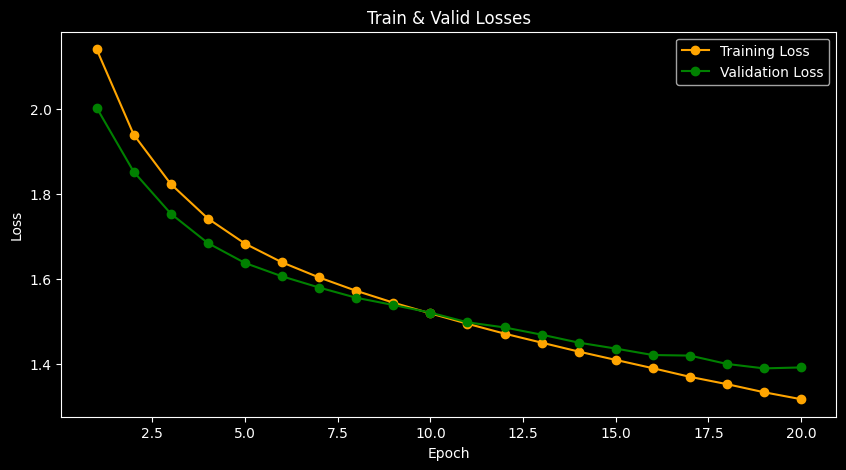


Best model on Validation is at epoch: 19


In [ ]:
torch.manual_seed(23)
MLP_model = MultiLayerPerceptron()

best_model_params_test_2 = NeuralNetwork(MLP_model,
                                  epochs=20,
                                  learning_rate=0.01,
                                  lr_change=1)

In this case the performance in validation is pretty better over epochs.

#### Third MLP
In this last test of MLP model, I've added a variable learning rate over the epochs, starting with 0.1 and gradually decreasing to about 0.001 at epoch 20.


Epoch:	1 with Learning Rate: 0.1

loss: 2.321432  [    0/48000]  batch: 0
loss: 2.009613  [ 5120/48000]  batch: 20
loss: 1.900245  [10240/48000]  batch: 40
loss: 1.762843  [15360/48000]  batch: 60
loss: 1.789327  [20480/48000]  batch: 80
loss: 1.689447  [25600/48000]  batch: 100
loss: 1.651012  [30720/48000]  batch: 120
loss: 1.778433  [35840/48000]  batch: 140
loss: 1.636936  [40960/48000]  batch: 160
loss: 1.734419  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 40.6%, Avg loss: 1.652033 


Epoch:	2 with Learning Rate: 0.064

loss: 1.680654  [    0/48000]  batch: 0
loss: 1.611343  [ 5120/48000]  batch: 20
loss: 1.657362  [10240/48000]  batch: 40
loss: 1.537713  [15360/48000]  batch: 60
loss: 1.538320  [20480/48000]  batch: 80
loss: 1.465687  [25600/48000]  batch: 100
loss: 1.425105  [30720/48000]  batch: 120
loss: 1.406390  [35840/48000]  batch: 140
loss: 1.555756  [40960/48000]  batch: 160
loss: 1.594500  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 46.8%, Avg l

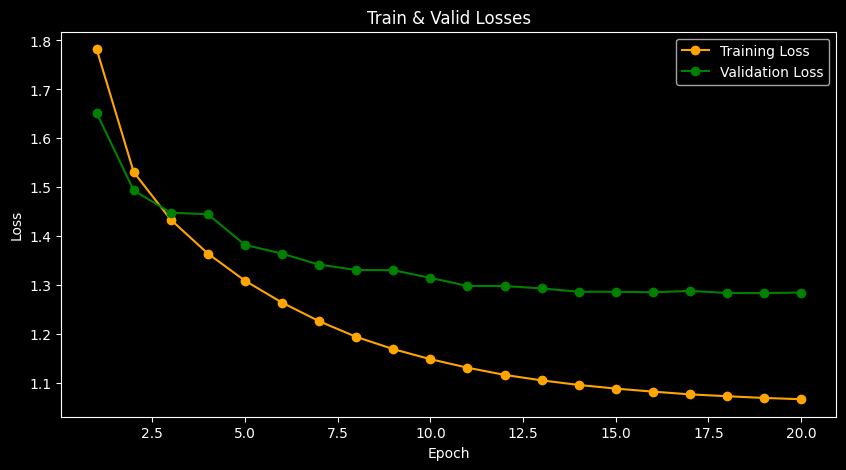


Best model on Validation is at epoch: 19


In [ ]:
torch.manual_seed(23)
MLP_model = MultiLayerPerceptron()

best_model_params_MLP = NeuralNetwork(MLP_model,
                                      epochs=20,
                                      learning_rate=0.1,
                                      lr_change=0.8)

We can notice that the loss training curve is monotonically decreasing, while the validation has a sort of plateau already at epoch 13 ca.

I'll be using this model as reference for CNN below.

#### Looking inside trained weights & biases MLP

In [ ]:
best_model_params_MLP

(OrderedDict([('linear_relu_stack.0.weight',
               tensor([[-6.3351e-03, -1.1094e-02, -4.9168e-03,  ..., -1.1815e-02,
                         3.7773e-03, -1.2239e-02],
                       [ 1.6217e-02,  1.2346e-02,  3.8290e-03,  ...,  2.4322e-02,
                         1.1883e-03,  3.0158e-02],
                       [-3.0357e-03,  1.3345e-02, -6.9794e-03,  ...,  9.9846e-03,
                         1.3274e-02,  1.6112e-02],
                       ...,
                       [ 1.0567e-03, -1.6734e-02, -2.9441e-03,  ..., -1.2613e-02,
                        -3.0843e-03, -7.4078e-03],
                       [ 2.8029e-03, -8.6228e-03,  1.1393e-02,  ...,  1.0559e-02,
                         2.6927e-02,  2.4592e-02],
                       [-1.6085e-02,  1.6634e-03,  1.2242e-02,  ..., -5.9481e-03,
                        -5.3308e-05,  1.2781e-02]])),
              ('linear_relu_stack.0.bias',
               tensor([ 0.0246, -0.0157, -0.0127,  0.0161,  0.0019, -0.0307,  0.000

#### Testing function

Hereafter, a function to test the model with the test set and plot a confusion matrix showing the behaviour of the model among all classes.

In [ ]:
def testing(model,
            best_model_params,
            test_DL=test_DL):

    # Load the best model parameters
    model.load_state_dict(best_model_params)

    # Testing
    loss_fun = nn.CrossEntropyLoss()

    size_te = len(test_DL.dataset)
    num_batch_te = len(test_DL)

    test_loss = 0
    test_correct = 0
    predictions = []
    labels = []

    with torch.no_grad():
        model.eval()  # eval mode

        for X, y in test_DL:
            pred = model(X)

            predictions.extend(pred.argmax(1).tolist())
            labels.extend(y.tolist())

            test_loss += loss_fun(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batch_te
    test_correct /= size_te

    print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # Confusion Matrix on Test Set
    confusionMatrix = confusion_matrix(labels, predictions)
    confusionMatrixDf = pd.DataFrame(confusionMatrix,
                                      index=[labels_map[i].title() for i in labels_map],
                                      columns=[labels_map[i].title() for i in labels_map])

    plt.figure(figsize=(10, 8))
    sb.heatmap(confusionMatrixDf, annot=True, fmt='d', cmap='rocket_r', cbar=True)
    plt.title('Confusion Matrix | Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Test Error: 
 Accuracy: 53.4%, Avg loss: 1.315105 



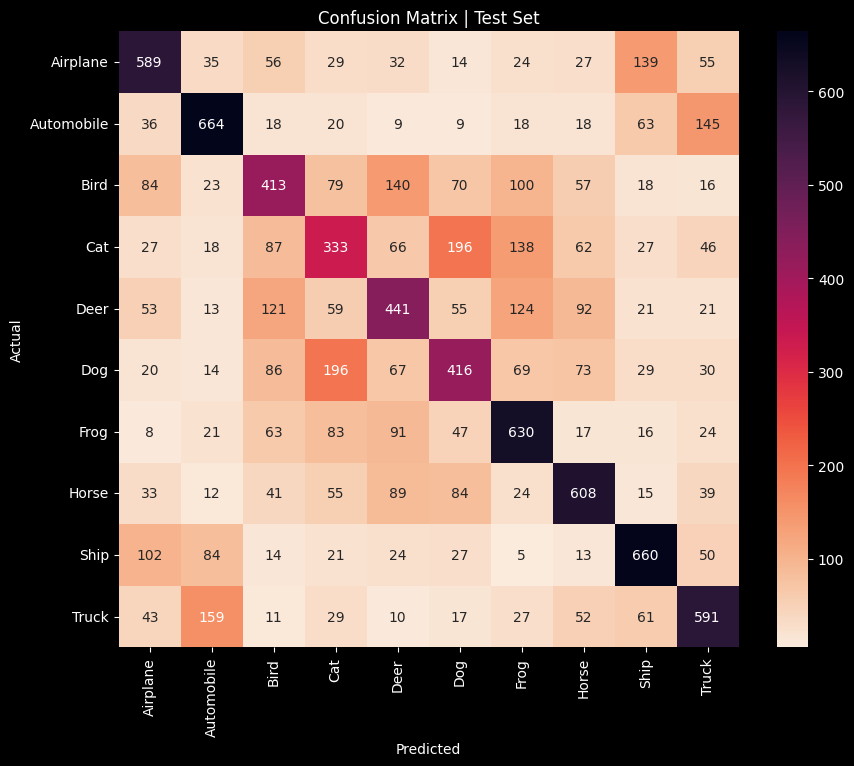

In [ ]:
torch.manual_seed(23)
MLP_model = MultiLayerPerceptron()

testing(MLP_model,
        best_model_params_MLP[0])

It makes sense that the accuracy on validation set is 53.7% and on test set is 53.4%.

The most misclassified by the model is Cat (accuracy of 33.3%) along with Dog and similarly, Deer with Bird.

While the best classified is Automobile with 66.4%.

The other classes perfom better, but still there is some ambiguity for the model in distinguishing:
- Airplane and Ships, maybe considering the lightblue background given by the Sea or the Sky
- Auto against Truck, which may have similar characteristics, like lights systems.

Finally, there is an imperfect simmetry among classes, e.g. Cat vs Dog and Dog vs Cat.

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

#### CNN

I've tested some configurations for CNN, at the end I've set it with two convolutional layers and a max pooling.

In [ ]:
# Your code here.

class ConvNN(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super(ConvNN, self).__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),  # 3 input channels (RGB), 64 kernels = out channels
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),  # for feature extraction

            torch.nn.Conv2d(64, 128, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            )

        self.classifier = torch.nn.Sequential(

            torch.nn.Dropout(),  # to prevent overfitting
            torch.nn.Linear(128 * 7 * 7, 4096),
            torch.nn.ReLU(),

            torch.nn.Linear(4096, num_classes),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### Image
In this snippet I've just tested if the non-trained CNN works on a random image.

A random image from the train dataset with index: 15715
Label:
	7, horse (Real)
	3, cat (Pred)



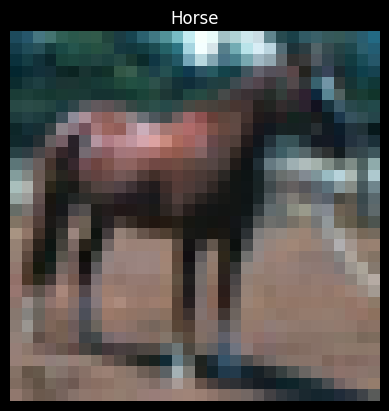

In [ ]:
import random

torch.manual_seed(23)
CNN_model = ConvNN()

index = random.randint(0, len(train_DL.dataset) - 1)

with torch.no_grad():

    CNN_model.eval()

    img = torch.unsqueeze(train_DL.dataset[index][0], dim=0)
    label = train_DL.dataset[index][1]

    pred = CNN_model(img)

    print(f"A random image from the train dataset with index: {index}\n"
          f"Label:\n\t{label}, {labels_map[label]} (Real)\n\t{pred.argmax().item()}, {labels_map[pred.argmax().item()]} (Pred)\n")

    img, label = train_data[index]
    plt.title(labels_map[label].title())
    plt.axis("off")
    plt.imshow(unnormalize(img, mean_tr, std_tr).permute(1,2,0))

#### CNN parameters

In [ ]:
torch.manual_seed(23)

CNN_model = ConvNN()
CNN_model
# CNN_model.state_dict()

ConvNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=4096, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)

### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before. Critically compare its performance with the MLP baseline above.

ConvNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=4096, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)

Epoch:	1 with Learning Rate: 0.1

loss: 2.302908  [    0/48000]  batch: 0
loss: 2.081029  [ 5120/48000]  batch: 20
loss: 1.934578  [10240/48000]  batch: 40
loss: 2.439988  [15360/48000]  batch: 60
loss: 1.889648  [20480/48000]  batch: 80
loss: 1.900568  [25600/48000]  batch: 100
loss: 1.868761  [30720/48000]  batch: 120
loss: 1.712209  [35840/48000]  batch: 140
loss: 1.647585  [40960/48000]  batch: 160
loss: 1.587329  [46080/48000]  batch: 180
Validation Error: 
 Accuracy: 43

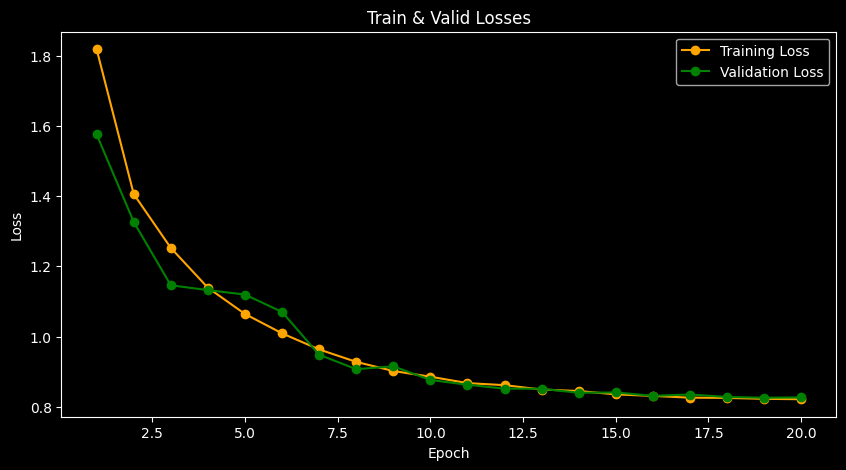


Best model on Validation is at epoch: 19


In [ ]:
torch.manual_seed(23)
CNN_model = ConvNN()
print(CNN_model)

best_model_params_CNN = NeuralNetwork(CNN_model,
                                      epochs=20,
                                      learning_rate=0.1,
                                      lr_change=0.8)

I would have expected more difference in between train and validation losses.

#### Looking inside trained weights & biases CNN

In [ ]:
best_model_params_CNN

(OrderedDict([('features.0.weight',
               tensor([[[[ 4.4435e-02,  2.6895e-03,  1.5843e-02, -1.6442e-03,  1.3941e-01],
                         [-4.5551e-02,  3.4910e-03,  1.3822e-01,  5.9480e-02, -4.4604e-02],
                         [ 3.1589e-02, -8.6219e-02,  6.3343e-02,  1.8852e-02,  1.2354e-02],
                         [-1.0730e-01, -8.8251e-02, -8.8370e-02, -5.7124e-02, -9.0212e-02],
                         [ 1.4685e-02, -5.9392e-02, -4.9363e-02, -8.6299e-02, -2.0745e-02]],
               
                        [[-6.8885e-02,  1.2216e-01,  9.1237e-02,  1.0670e-01, -4.0582e-02],
                         [ 3.2012e-02,  3.2993e-02, -7.2158e-03,  6.4764e-02,  6.4142e-02],
                         [-7.7825e-02, -9.3601e-03, -1.0279e-01,  4.6407e-02,  7.7562e-02],
                         [-3.1940e-02, -1.2336e-01, -1.0238e-01,  1.1521e-02, -9.2665e-02],
                         [-7.0046e-04, -6.9228e-02, -3.0116e-02, -9.8187e-02, -1.4084e-01]],
               
          

#### CNN Confusion Matrix

Test Error: 
 Accuracy: 70.4%, Avg loss: 0.859798 



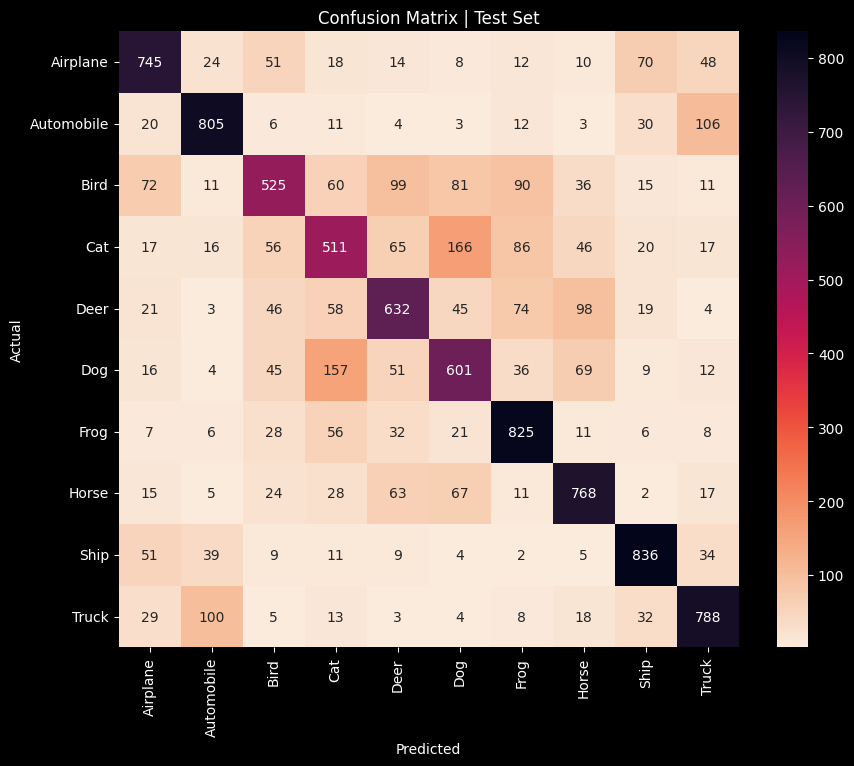

In [ ]:
# Your code here.

torch.manual_seed(23)
CNN_model = ConvNN()

testing(CNN_model,
        best_model_params_CNN[0])

Despite a longer training time, the CNN model performed much better than the MLP with a accuracy of 70,4% vs 53,7% on Test set.

Both models have similar tendency to predict worse some classes, such as Cat.